# Solving the Poisson equation with Dirichlet boundary conditions and approximate negative norm

Given measurements of $f$ of the form 

$$
\int_{\Omega} f(x)\psi_i(x)dx
$$
we will approximate negative sobolev norm as 

$$
[f, \psi]A[f, \psi]
$$
where 
$$
A_{i,j} = \int_{\Omega} \psi_i \Delta^{-1} \psi_j
$$
where 
$$
 \Delta^{-1}\psi (y) = \int_\Omega G(x,y)\psi(x)dx
$$
In certain cases, we have access to explicit solutions although in general we would need to compute the Green's function numerically.

Example:

Consider the 1-D PDE:

\begin{aligned}
u''(x) + u(x) = f(x) \\
u(0) = 0, u\Big(\frac{\pi}{2}\Big) = 0
\end{aligned}

The Green's function has the representation:
$$
G(x,y) = \begin{cases}
-\cos(y)\sin(x) & x < y\\
-\sin(y)\cos(x)& y \leq x
\end{cases}
$$

In [2]:
import jax.numpy as jnp
from jax import random
from jax import scipy 

import matplotlib.pyplot as plt


from jax.config import config
config.update("jax_enable_x64", True)

C:\Users\Matthieu\AppData\Local\Temp\ipykernel_29108\1496758469.py:8: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config


In [9]:
import utils_rough_pde
from utils_rough_pde import *
from utilities_kernel_matern import *

In [44]:
lower = 0.0
upper = jnp.pi/2

L =upper -lower 
x = jnp.linspace(0, L, 2000)

In [45]:
n_order = 10
from scipy.special import roots_legendre
x_q, w_q = roots_legendre(n_order)



In [46]:
# Construct the measurements
n_meas = 20
epsilon_values =  jnp.array([1/(n_meas*2)])
loc_values = jnp.linspace(lower + epsilon_values[0], upper - epsilon_values[0],  int(L/(2*epsilon_values[0])))
support = jnp.array([loc_values - epsilon_values[0], loc_values + epsilon_values[0]]).T
vol = support[:,1] - support[:,0]
N_test_functions = loc_values.shape[0]

In [47]:
epsilon_values, loc_values.shape

(Array([0.025], dtype=float64), (31,))

In [48]:
N_test_functions, epsilon_values.shape

(31, (1,))

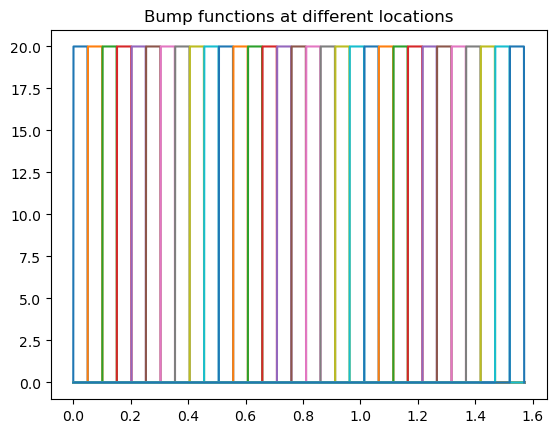

In [30]:
bump_values = vmap_indicator(x, epsilon_values, loc_values)

for i, loc in enumerate(loc_values):
    plt.plot(x, bump_values[:, 0, i])
plt.title("Bump functions at different locations")
plt.show()

## Computing the 

In [35]:
root_psi, w_psi = vmap_root_interval(x_q, w_q, support)
psi_matrix = indicator_vector(root_psi, epsilon_values, loc_values)

In [36]:
psi_matrix.shape

(31, 10)